## Single Image Inference using Chestxray Dataset

Following are the modules that are necessarily required to run the code

Tested with: BigDL-0.7.2, Analytics Zoo-0.4.0, Pyspark-2.1.0

In [1]:
%pylab inline
from bigdl.nn.layer import Model
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType, ArrayType

from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.models.image.imageclassification import *
from zoo.pipeline.nnframes import *
from zoo.pipeline.api.net import Net
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.metrics import AUC
from zoo.pipeline.nnframes import NNEstimator
from zoo.pipeline.api.keras.objectives import BinaryCrossEntropy

import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sparkConf = create_spark_conf().setAppName("ChestXray_Inference")
sc = init_nncontext(sparkConf)
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
sqlContext = SQLContext(sc)

Populating the interactive namespace from numpy and matplotlib


/usr/lib64/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools


## Loading data paths

Loading the data of image and label from HDFS location

In [2]:
test_image_path = "file:///home/leelau/github/chestxray_tests/images/00000001_002.png"
label_path = "file:///home/leelau/github/chestxray_tests/Data_Entry_2017.csv"

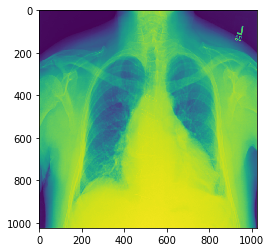

In [3]:
img=mpimg.imread(test_image_path)
imgplot = plt.imshow(img)
plt.show()

Labels

In [4]:
%%time
label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
               "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
label_map = {k: v for v, k in enumerate(label_texts)}

def text_to_label(text):
    arr = [0.0] * len(label_texts)
    for l in text.split("|"):
        if l != "No Finding":
            arr[label_map[l]] = 1.0
    return arr

label_length = len(label_texts)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16 µs


Create Inference Dataframe

In [5]:
%%time
getLabel = udf(lambda x: text_to_label(x), ArrayType(DoubleType()))
getName = udf(lambda row: os.path.basename(row[0]), StringType())
test_imageDF = NNImageReader.readImages(test_image_path, sc, resizeH=256, resizeW=256, image_codec=1)\
                .withColumn("Image Index", getName(col('image')))
imageDF = test_imageDF.withColumnRenamed('Image Index', 'Image_Index')
labelDF = sqlContext.read.option('timestampFormat', 'yyyy/MM/dd HH:mm:ss ZZ')\
            .load(label_path, format="csv", sep=",", inferSchema="true", header="true")\
            .select("Image Index", "Finding Labels")\
            .withColumn("label", getLabel(col('Finding Labels')))\
            .withColumnRenamed('Image Index', 'Image_Index')
labelDF1 = labelDF.withColumnRenamed('Image Index', 'Image_Index')\
            .withColumnRenamed('Finding Labels', 'Finding_Labels')
trainDF = imageDF.join(labelDF1, on="Image_Index", how="inner")

CPU times: user 17.5 ms, sys: 4.96 ms, total: 22.5 ms
Wall time: 3.12 s


Load ResNet-50 Analytics Zoo Keras Model

In [6]:
%%time
resnet_zoo_model = Net.load("file:///home/leelau/github/chestxray_tests/model/model.bigdl", "file:///home/leelau/github/chestxray_tests/model/model.bin")
type(resnet_zoo_model)

CPU times: user 819 µs, sys: 2.65 ms, total: 3.47 ms
Wall time: 5.25 s


Inference using the loaded ResNet Model which is used on trainDF

In [7]:
%%time
def predict(model, inputdf, image_feature_col = "image", batchsize=4):
    """
    Predict output of when inputdf is passed through model
    """
    transformer = ChainedPreprocessing([
        RowToImageFeature(),
        ImageCenterCrop(224, 224),
        ImageChannelNormalize(123.68, 116.779, 103.939),
        ImageMatToTensor(),
        ImageFeatureToTensor()])
    classifier_model = NNModel(model, transformer).setFeaturesCol(image_feature_col)\
                        .setBatchSize(batchsize)
    output = classifier_model.transform(inputdf)
    return output

def show_prediction_output(predDF):
    """
    Display the output size and array
    """
    print(predDF.show(1))
    print("length of prediction array : ", len(predDF.collect()[0].prediction))
    predictions_list = predDF.collect()[0].prediction
    labelList = predDF.collect()[0].label
    print("{:<15} - {:<25} - {:<15}".format('Finding_Labels', 'Prediction', 'Label'))
    print("{:<15} - {:<25} - {:<15}".format('-'*len('Finding_Labels'), '-'*len('Prediction'), '-'*len('Label')))
    for indx in range(0, len(predictions_list)):
        print("{:<15} - {:<25} - {:<15}".format(label_texts[indx], predictions_list[indx], labelList[indx]))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


Check output of the loaded ResNet model which is used in the Inference Dataframe

In [8]:
%%time
output = predict(resnet_zoo_model, trainDF)
show_prediction_output(output)

creating: createRowToImageFeature
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing
creating: createTensorToSample
creating: createChainedPreprocessing
creating: createNNModel
+----------------+--------------------+--------------------+--------------------+--------------------+
|     Image_Index|               image|      Finding_Labels|               label|          prediction|
+----------------+--------------------+--------------------+--------------------+--------------------+
|00000001_002.png|[file:/home/leela...|Cardiomegaly|Effu...|[0.0, 1.0, 1.0, 0...|[0.16969706, 0.98...|
+----------------+--------------------+--------------------+--------------------+--------------------+

None
('length of prediction array : ', 14)
Finding_Labels  - Prediction                - Label          
--------------  - ----------                - -----          
Atelectasis   